In [1]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from imutils.video import VideoStream
import imutils

In [2]:
c=0

for filename in os.listdir("mask"):
    if(filename.endswith(".jpg")):
        img = Image.open("mask/"+filename).convert('L')
        a = np.array(img)
        if(c==0):
            n=a.reshape(1,-1)
        else:    
            n= np.append(n,a.reshape(1,-1),axis=0)
        c+=1
y=np.ones((c,1))

In [3]:
n.shape,y.shape

((32, 1600), (32, 1))

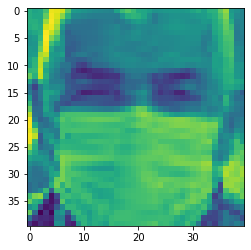

In [4]:
plt.imshow(n[29].reshape(40,40))

In [5]:
c=0

for filename in os.listdir("no_mask"):
    if(filename.endswith(".jpg")):
        img = Image.open("no_mask/"+filename).convert('L')
        a = np.array(img)
        n= np.append(n,a.reshape(1,-1),axis=0)
        c+=1
y=np.append(y,np.zeros((c,1)))

In [6]:
n.shape,y.shape

((166, 1600), (166,))

In [7]:
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize

In [8]:
#n_mod = normalize(n, norm='l2', axis=1, copy=True, return_norm=False)

In [9]:
n,y = shuffle(n,y)

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
model = LogisticRegression(max_iter=5000)

In [12]:
n[0]

array([217, 216, 217, ..., 216, 195, 207], dtype=uint8)

In [13]:
#n_mod[0]

In [14]:
model.fit(n,y)

LogisticRegression(max_iter=5000)

In [15]:
model.predict(n[:15,:]),y[:15]

(array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [16]:
model.score(n,y)

1.0

In [17]:
imgTest = Image.open('test.jpg').convert('L')

In [18]:
xtest = np.array(imgTest).reshape(1,-1)

In [19]:
#xtest_mod = normalize(xtest, norm='l2', axis=1, copy=True, return_norm=False)

In [20]:
 if model.predict(xtest)[0] == 0:
    print("not wearing mask")
 else :
    print("wearing mask")

wearing mask


In [21]:
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
cap = cv2.VideoCapture(0)

In [22]:
while True:
    _, img = cap.read()

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    arr= np.array(img)
    # Detect the faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 1)
    
    
    # Draw the rectangle around each face
    for (x, y, w, h) in faces:
          detect = Image.fromarray(arr[y:y+h,x:x+w,], 'L')
          detect = detect.resize((40,40))
          detectArray = np.array(detect).reshape(1,-1)
          if model.predict(detectArray)[0] == 0:
             cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
          else :
             cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    
    # Display
    cv2.imshow('img', img)

    # Stop if escape key is pressed
    k = cv2.waitKey(30) & 0xff
    if k==27:
        break
        
# Release the VideoCapture object
cap.release()

In [21]:
prototxtPath = r"face_detector\deploy.prototxt.txt"
weightsPath = r"face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)
vs = VideoStream(src=0).start()

In [ ]:
while True:
    frame = vs.read()
    #frame = imutils.resize(frame, width=400)
    pil = np.array(frame)
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),(104.0, 177.0, 123.0))


    faceNet.setInput(blob)
    detections = faceNet.forward()


    faces = []
    locs = []
    preds = []
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.15:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            #cv2.rectangle(frame, (startX, startY), (endX, endY), (255,0,0), 2)
            if(startX<h and endX<h and startY < w and endY<w):
                detect = Image.fromarray(pil[startY:endY,startX:endX,], 'RGB')
                detect = detect.convert('L')
                detect = detect.resize((40,40))
                detectArray = np.array(detect).reshape(1,-1)
                if model.predict(detectArray)[0] == 0:
                    cv2.rectangle(frame, (startX, startY), (endX, endY), (255,0,0), 2)
                    cv2.putText(frame, "No Mask", (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255,0,0), 2)
                else :
                    cv2.rectangle(frame, (startX, startY), (endX, endY), (0,255,0), 2)
                    cv2.putText(frame, "Mask", (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0,255,0), 2)
    
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break